# Bose-Einstein Condensates

In [1]:
using KadanoffBaym
using LinearAlgebra

using PyPlot
# PyPlot.plt.style.use("./paper.mplstyle")

## Model

In this notebook we will use `KadanoffBaym.jl` to study _dephasing_ in Bose-Einstein condensates (see Chp. 3 [here](https://bonndoc.ulb.uni-bonn.de/xmlui/handle/20.500.11811/8961)). To do this, we will need to solve _one-time_ differential equations for the condensate amplitude $\varphi(t)$ and the equal-time Keldysh Green function $G^K(t, t)$.

The Lindblad master equation describing this systems reads

\begin{align}
    \begin{split}
    	\dot{\hat{\rho}} &= -i\omega_0[a^\dagger a, \hat{\rho}] +\frac{\lambda}{2}\left\{ 2a\hat{\rho} a^{\dagger} - \left( a^{\dagger}a\hat{\rho} + \hat{\rho} a^{\dagger}a \right)\right\} + \frac{\gamma}{2}\left\{ 2a^{\dagger}\hat{\rho} a - \left( aa^{\dagger}\hat{\rho} + \hat{\rho} aa^{\dagger} \right)\right\} \\
        &+ D\left\{ 2a^{\dagger}a\hat{\rho} a^{\dagger}a - \left( a^{\dagger}aa^{\dagger}a\hat{\rho} + \hat{\rho} a^{\dagger}aa^{\dagger}a \right)\right\},    
    \end{split}
\end{align}

where $\lambda > 0$ is the loss parameter, $\gamma > 0$ represents the corresponding gain, and $D > 0$ is the constant that introduces dephasing. The derivation for the equations of motion for $\varphi(t)$ and $G^K(t, t)$ is again given [here](https://bonndoc.ulb.uni-bonn.de/xmlui/handle/20.500.11811/8961) and leads to

\begin{align}
    \begin{split}
    \dot{\varphi}(t) &=  -i\omega_0\varphi(t) -\frac{1}{2}{(\lambda - \gamma + {2} D)}\varphi(t), \\
    \dot{G}^K(t, t) &= -{(\lambda - \gamma)}G^K(t, t) - i{\left(\lambda + \gamma + {2} D |\varphi(t)|^2\right)}.
    \end{split}
\end{align}

To make these expressions more transparent, we set $\varphi(t) = \sqrt{2N(t)}\mathrm{e}^{i \theta(t)}$ and $G^K(t, t) = -i{(2\delta N(t) + 1)}$, where $N$ and $\delta N$ are the condensate and non-condensate occupation, respectively. For these quantities, we obtain

\begin{align}
    \begin{split}
    \dot{N} &=  {(\gamma - \lambda -{2} D)}N, \\
    \delta \dot{N} &=  \gamma{(\delta N + 1)} - \lambda\delta N + {2}DN.
    \end{split}
\end{align}

## Defining the model

In [2]:
# parameters
ω₀ = 1.0
λ = 0.0
γ = 0.0
D = 1.0 

# initial occupations
N = 1.0
δN = 0.0

# One-time function for the condensate
φ = GreenFunction(zeros(ComplexF64, 1), OnePoint)

# Allocate the initial Green functions (time arguments at the end)
GK = GreenFunction(zeros(ComplexF64, 1, 1), SkewHermitian)

# Initial conditions
GK[1, 1] = -im * (2δN + 1)
φ[1] = sqrt(2N);

In [3]:
# we leave the vertical equation empty since we can solve for GK in equal-time only
function fv!(out, ts, h1, h2, t, t′)
    out[1] = zero(out[1])
end

# diagonal equation for GK
function fd!(out, ts, h1, h2, t, _)
    out[1] = -(λ - γ) * GK[t, t] - im * (λ + γ + 2D * abs2(φ[t]))
end

# one-time equation for condensate amplitude
function f1!(out, ts, h1, t)
    out[1] = -im * ω₀ * φ[t] - (1/2) * (λ - γ + 2D) * φ[t]
end

f1! (generic function with 1 method)

## Solving the example

In [4]:
# call the solver
sol = kbsolve!(fv!, fd!, [GK,], (0.0, 1.0); atol=1e-6, rtol=1e-4, v0 = [φ,], f1! =f1!);

## Plots

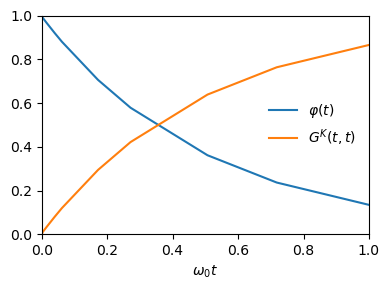

In [5]:
let
    fig = figure(figsize=(4, 3))

    ax = subplot(111)
    plot(ω₀ .* sol.t, abs2.(φ[:]) / 2 |> real, ls="-", c="C0", label="\$\\varphi(t)\$", lw=1.5)
    plot(ω₀ .* sol.t, [(im * GK[k, k] - 1) / 2 for k in 1:size(sol.t)[1]] |> real, ls="-", c="C1", label="\$G^K(t, t)\$", lw=1.5)
    ax.set_xlabel("\$ \\omega_0 t\$")
    ax.set_xlim(0, sol.t[end])
    ax.set_ylim(0.0, 1.0)
    ax.legend(frameon=false)
    tight_layout()
    fig
end;